# EfficientNet B0 Image Classifier

**This notebook should run correctly both in colab and on jupyter.**
- Uses stratified sampling (making sure all classes have same ratio in all sets).
- Uses metadata from **'data/encoded_columns_data'**.
- Uses images from folder **'directly_processed_images'**.

## **Setup**

In [ ]:
# use ice cream to conveniently print stuff
!pip install icecream

In [ ]:
import sys
on_colab = 'google.colab' in sys.modules
if on_colab:
  print("Running notebook on google colab")
else:
  print("Notebook not running on google colab")
  !pip install icecream

Running notebook on google colab


In [ ]:
# imports
from icecream import ic
import pandas as pd
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import timeit
import torchvision
# import torchsummary
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# from torchsummary import summary
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

# to save session
import pickle

from tqdm import tqdm

In [ ]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("PyTorch version:")
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

PyTorch version:
2.2.1+cu121
Using cuda device


## Define paths to image folder & metadata

In [ ]:
# paths
if on_colab:
  metadata_path = '/content/drive/MyDrive/CDS Project/data/encoded_final_data.csv'
  images_path = '/content/drive/MyDrive/CDS Project/directly_processed_images'
else:
  metadata_path = '../data/encoded_final_data.csv'
  images_path = '../directly_processed_images'

In [ ]:
metadata_df = pd.read_csv(metadata_path)
metadata_df

,image_id,age,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,female,male,target
0,ISIC_5136612,65.0,0,0,0,0,1,0,0,1,0
1,ISIC_0031002,65.0,0,0,0,0,0,1,0,1,0
2,ISIC_0026875,35.0,0,0,0,0,0,1,1,0,1
3,ISIC_0024371,70.0,0,1,0,0,0,0,0,1,2
4,ISIC_0027263,85.0,0,0,0,0,1,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...
1395,ISIC_0027531,65.0,0,1,0,0,0,0,0,1,5
1396,ISIC_0025691,50.0,0,0,0,0,1,0,1,0,5
1397,ISIC_0028381,55.0,1,0,0,0,0,0,1,0,6
1398,ISIC_0033254,15.0,0,0,0,0,1,0,0,1,4


In [ ]:
num_images = len([file for file in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, file))])
print("Number of images: ", num_images)

Number of images:  1400


## Train test split (Stratified Sampling)

In [ ]:
# Split data in features and target:
X = metadata_df  # features
y = metadata_df['target']  # target

# Splitting into train, test, and validation sets with stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp)

ic(len(X_train), len(X_test), len(X_val))

ic| len(X_train): 1120, len(X_test): 140, len(X_val): 140


(1120, 140, 140)

In [ ]:
# Resizing to 224x224, some transformations/augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224, padding=4),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # random adjustments
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # for blurry images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # standard normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Define CustomDataset function

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx, 0]  # Get image ID of sample using the metadata index
        img_name = os.path.join(self.images_path, f'processed_{img_id}.jpg')  # name of image files
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image file not found: {img_name}")

        image = Image.open(img_name)
        row = metadata_df[metadata_df['image_id'] == img_id]
        label = row.iloc[0]['target']

        if self.transform is not None:
            image = self.transform(image)

        # # extract demographic features
        # age = torch.tensor(self.metadata.iloc[idx, 1])
        # localization = torch.tensor(self.metadata.iloc[idx, 3])
        # gender = torch.tensor(self.metadata.iloc[idx, 4])

        return image, label

## Define train, validation and test datasets/dataloaders

In [ ]:
# custom datasets
train_dataset = CustomDataset(metadata=X_train, transform=train_transform)
val_dataset = CustomDataset(metadata=X_val, transform=val_transform)
test_dataset = CustomDataset(metadata=X_test, transform=val_transform)

# Create data loaders (optimized for faster loading)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)

# check
ic(len(train_dataset), len(val_dataset), len(test_dataset))

ic| len(train_dataset): 1120
    len(val_dataset): 140
    len(test_dataset): 140


(1120, 140, 140)

In [ ]:
# test to check some samples in split sets
for index in range(20):

  image, label = train_dataset[index]

  # Display information about the sample
  # print("Random Sample Index:", index)
  # print("Image Shape:", image.shape)
  # print("Label:", label)
  # print(type(label))

  # Display the image
  plt.imshow(image.permute(1, 2, 0))  # permute to rearrange dimensions from CxHxW to HxWxC
  plt.title(f"Label: {label}")
  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

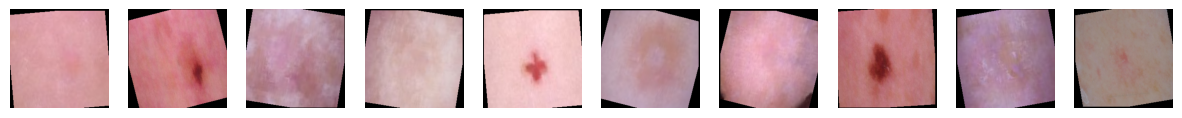

In [ ]:
# Get a single batch of data from the train_loader
# check if transformations are applied
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert the images tensor to numpy format for plotting
images = images.numpy()

# Plot some random images from the batch
num_images_to_show = 10  # Number of images you want to display

# Set up the figure
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # Convert image to the range [0, 1] and transpose to HWC format
    img = np.transpose(images[i], (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Plot the image
    axes[i].imshow(img)
    axes[i].axis('off')
    # axes[i].set_title(f'Label: {labels[i]}')

# Show the figure
plt.show()

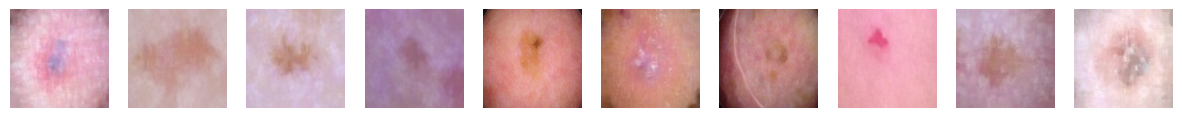

In [ ]:
# Get a single batch of data from the test_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Convert the images tensor to numpy format for plotting
images = images.numpy()

# Plot some random images from the batch
num_images_to_show = 10  # Number of images you want to display

# Set up the figure
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # Convert image to the range [0, 1] and transpose to HWC format
    img = np.transpose(images[i], (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Plot the image
    axes[i].imshow(img)
    axes[i].axis('off')
    # axes[i].set_title(f'Label: {labels[i]}')

# Show the figure
plt.show()

## EfficientNet + modified last layer

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
from efficientnet_pytorch import EfficientNet

# Choose the desired EfficientNet variant and size (e.g., 'efficientnet-b0')
model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


#### Modify last layer
- adjust to the appropriate number of output classes (7)

In [ ]:
num_features = model_efficientnet._fc.in_features
model_efficientnet._fc = nn.Linear(num_features, 7)

#### Adam optimizer + CEL

In [ ]:
# Loss function: CEL
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model_efficientnet.parameters(), lr=0.001)
criterion.to(device)
model_efficientnet.to(device)

### Training

In [ ]:
# Training for one epoch

def train_model(model, criterion, optimizer, train_loader, val_loader):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        labels = labels.long()
        labels = labels.to(device)
        images = images.to(device)
        optimizer.zero_grad()
        # forward propagation, i.e. get predictions
        outputs = model(images)
        # calculate loss and backpropagate to model paramters:
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels=labels.long()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / total_val

    return train_loss, val_loss, train_acc, val_acc

In [ ]:
# specify epochs to train
total_epochs = 30

tl = []
vl = []
ta = []
va = []

for epoch in range(total_epochs):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_efficientnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

In [ ]:
# extra epochs (if needed)

for epoch in range(10):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_efficientnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {30+epoch+1}/{40}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 31/40, Train Loss: 0.0722, Train Acc: 0.9750, Val Loss: 1.7290, Val Acc: 0.7357, Elapsed Time: 13.60 seconds


100%|██████████| 35/35 [00:10<00:00,  3.23it/s]


Epoch 32/40, Train Loss: 0.0579, Train Acc: 0.9759, Val Loss: 1.6320, Val Acc: 0.7429, Elapsed Time: 11.75 seconds


100%|██████████| 35/35 [00:11<00:00,  3.13it/s]


Epoch 33/40, Train Loss: 0.0551, Train Acc: 0.9786, Val Loss: 1.5498, Val Acc: 0.7143, Elapsed Time: 12.13 seconds


100%|██████████| 35/35 [00:10<00:00,  3.22it/s]


Epoch 34/40, Train Loss: 0.0574, Train Acc: 0.9812, Val Loss: 1.8503, Val Acc: 0.7071, Elapsed Time: 11.81 seconds


100%|██████████| 35/35 [00:10<00:00,  3.49it/s]


Epoch 35/40, Train Loss: 0.0588, Train Acc: 0.9839, Val Loss: 1.9277, Val Acc: 0.6000, Elapsed Time: 11.44 seconds


100%|██████████| 35/35 [00:11<00:00,  2.95it/s]


Epoch 36/40, Train Loss: 0.0793, Train Acc: 0.9723, Val Loss: 1.4726, Val Acc: 0.7500, Elapsed Time: 13.08 seconds


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Epoch 37/40, Train Loss: 0.1092, Train Acc: 0.9714, Val Loss: 1.7937, Val Acc: 0.6857, Elapsed Time: 13.84 seconds


100%|██████████| 35/35 [00:11<00:00,  3.08it/s]


Epoch 38/40, Train Loss: 0.0891, Train Acc: 0.9741, Val Loss: 1.9576, Val Acc: 0.6786, Elapsed Time: 12.30 seconds


100%|██████████| 35/35 [00:09<00:00,  3.65it/s]


Epoch 39/40, Train Loss: 0.0703, Train Acc: 0.9786, Val Loss: 1.5193, Val Acc: 0.6786, Elapsed Time: 10.94 seconds


100%|██████████| 35/35 [00:11<00:00,  3.15it/s]


Epoch 40/40, Train Loss: 0.0395, Train Acc: 0.9875, Val Loss: 1.7088, Val Acc: 0.7357, Elapsed Time: 12.10 seconds


### Visualisation

In [ ]:
# visualisation function
def plotResults():
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,tl,epovec,va,epovec,vl,linewidth=3)
    plt.legend(('Training Accuracy','Training Loss','Validation Accuracy','Validation Loss'))

    # make the graph understandable:
    plt.title("Losses and Accuracies")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.show()

In [ ]:
# plot loss function
def plotLosses():
    plt.figure(figsize=(10,6))
    epovec=range(len(tl))
    plt.plot(epovec,tl,epovec,vl,linewidth=3)
    plt.legend(('Training Loss', 'Validation Loss'))

    # make the graph understandable:
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
# plot accuracies function
def plotAccuracies():
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,va,linewidth=3)
    plt.legend(('Training Accuracy', 'Validation Accuracy'))

    # make the graph understandable:
    plt.title("Training and Validation Accuracies")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
# evaluate model function
def evaluate_model(model, criterion, data_loader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss /= len(data_loader.dataset)
    accuracy = correct / total

    return loss, accuracy, all_predictions, all_labels

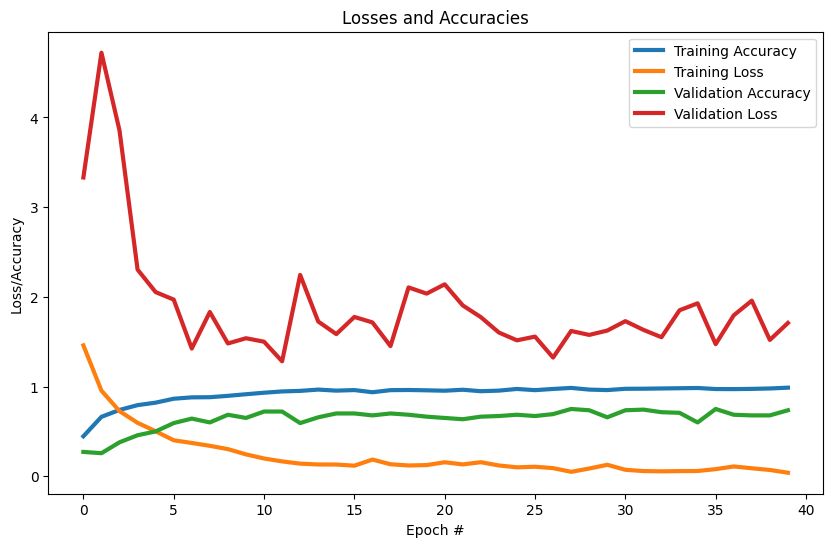

In [ ]:
plotResults()

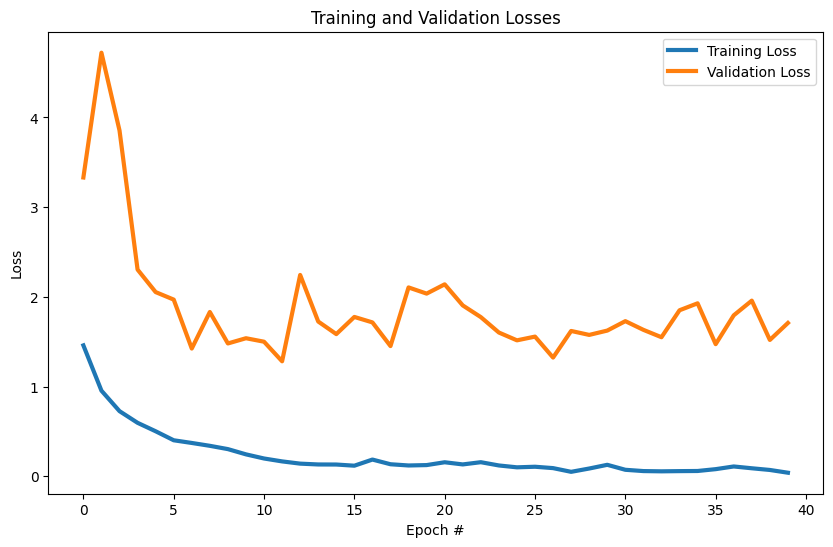

In [ ]:
# plot losses separately
plotLosses()

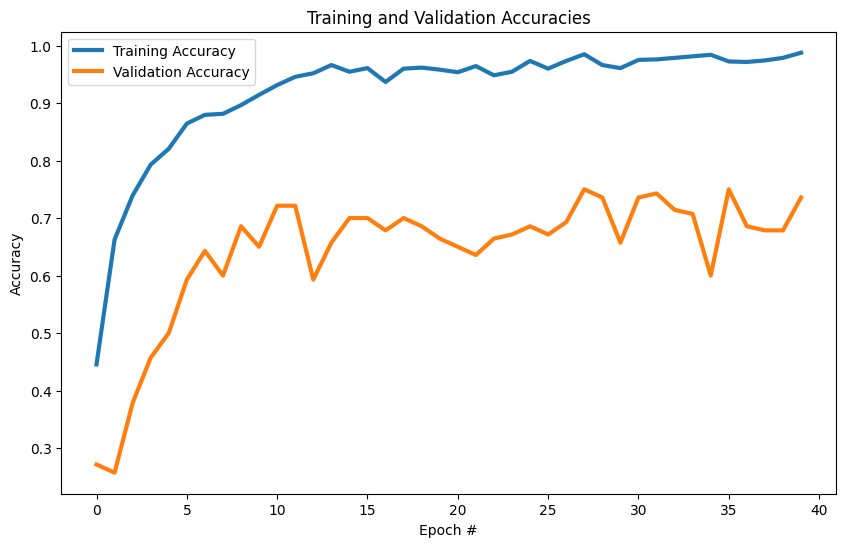

In [ ]:
# plot accuracies separately
plotAccuracies()

### Evaluation on Test Set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model
test_loss, test_accuracy, all_predictions, all_labels = evaluate_model(model_efficientnet, criterion, test_loader)

# Compute classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Compute accuracy per class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Accuracy per Class:", class_accuracy)
print("Test accuracy: ", test_accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.52      0.60      0.56        20
           2       0.47      0.45      0.46        20
           3       0.50      0.50      0.50        20
           4       0.90      0.90      0.90        20
           5       0.76      0.65      0.70        20
           6       0.74      0.70      0.72        20

    accuracy                           0.68       140
   macro avg       0.68      0.68      0.68       140
weighted avg       0.68      0.68      0.68       140

Confusion Matrix:
 [[19  0  0  1  0  0  0]
 [ 1 12  3  2  0  1  1]
 [ 0  7  9  1  0  1  2]
 [ 1  4  3 10  1  1  0]
 [ 0  0  0  2 18  0  0]
 [ 1  0  2  1  1 13  2]
 [ 0  0  2  3  0  1 14]]
Accuracy per Class: [0.95 0.6  0.45 0.5  0.9  0.65 0.7 ]
Test accuracy:  0.6785714285714286


### Save model & parameters

In [ ]:
# define saving paths
if on_colab:
  save_to_path = '/content/drive/MyDrive/CDS Project/saved_models/efficientnet_classifier_40epochs.pth'
  save_params_path = '/content/drive/MyDrive/CDS Project/saved_models/efficientnet_classifier_40epochs_params.pth'
else:
  save_to_path = '../saved_models/efficientnet_classifier_40epochs.pth'
  save_params_path = '../saved_models/efficientnet_classifier_40epochs_params.pth'

In [ ]:
torch.save(model_efficientnet, save_to_path)
torch.save(model_efficientnet.state_dict(), save_params_path)